<a href="https://colab.research.google.com/github/DanieleBaiocco/IPCV_assignment2/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

In [1]:
!pip install --upgrade calflops

In [2]:
from calflops import calculate_flops

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [3]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [4]:
!pip install thop

In [5]:
!pip install torchmetrics

In [6]:
from pathlib import Path
from PIL import Image
import PIL
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Callable, Optional
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import torchmetrics
from torchsummary import summary
import numpy as np
import random
import torchvision
import  matplotlib.pyplot as plt
import os
import copy
import pandas as pd

In [7]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform: Callable[[PIL.Image.Image], Tensor]) -> None:
        super().__init__()
        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]
        tensor_img = self.transform(img).float()
        return tensor_img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []
        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path)
                labels.append(int(label))
        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [8]:
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PENSO CHE LA COSA MIGLIORE DA FARE SIA INIZIARE CON UN MODELLO MOLTO COMPLICATO CHE OVERFITTI SUL TRAINING DATA. A QUEL PUNTO INSERIRE DELLE REGULARIZATION TECNIQUES CHE MI FACCIANO ARRIVARE A UNA EFFECTIVE CAPACITY OTTIMALE.

In [9]:
!pip install mypy
# Simple mypy cell magic for Colab
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
from mypy import api

@register_cell_magic
def mypy(line, cell):
    for output in api.run(['-c', '\n' + cell] + line.split()):
        if output and not output.startswith('Success'):
            raise TypeError(output)
    get_ipython().run_cell(cell)

In [10]:
resize_size = 300
crop_size = 256

In [11]:
def base_transform(resize_size, crop_size):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor()])
def train_transform(crop_size, mean, std):
    return transforms.Compose([transforms.RandomResizedCrop(crop_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])
def val_transform(resize_size, crop_size, mean, std):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])

In [12]:
#%%mypy --ignore-missing-imports
def create_dataloader(split: str,
                      transform: Callable[[PIL.Image.Image],Tensor],
                      dataset_creation: Callable[[str, Callable[[PIL.Image.Image],Tensor]], Dataset],
                      batch_size: int,
                      shuffle: bool,
                      num_workers: int) -> DataLoader:
      dataset = dataset_creation(split, transform)
      return DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)

In [13]:
def compute_sums(loader):
    sum_red = 0.0
    sum_green = 0.0
    sum_blue = 0.0
    num_pixels = 0

    for images, _ in loader:
        sum_red += images[:, 0, :, :].sum().item()
        sum_green += images[:, 1, :, :].sum().item()
        sum_blue += images[:, 2, :, :].sum().item()
        num_pixels += images[:, 0, :, :].numel()

    return sum_red, sum_green, sum_blue, num_pixels

def compute_means(sum_red, sum_green, sum_blue, num_pixels):
    mean_red = sum_red / num_pixels
    mean_green = sum_green / num_pixels
    mean_blue = sum_blue / num_pixels
    return mean_red, mean_green, mean_blue

def compute_sum_of_squared_diff(loader, mean_red, mean_green, mean_blue):
    sum_red_diff_sq = 0.0
    sum_green_diff_sq = 0.0
    sum_blue_diff_sq = 0.0

    for images, _ in loader:
        sum_red_diff_sq += ((images[:, 0, :, :] - mean_red) ** 2).sum().item()
        sum_green_diff_sq += ((images[:, 1, :, :] - mean_green) ** 2).sum().item()
        sum_blue_diff_sq += ((images[:, 2, :, :] - mean_blue) ** 2).sum().item()

    return sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq

def compute_std(sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq, num_pixels):
    std_red = (sum_red_diff_sq / num_pixels) ** 0.5
    std_green = (sum_green_diff_sq / num_pixels) ** 0.5
    std_blue = (sum_blue_diff_sq / num_pixels) ** 0.5
    return std_red, std_green, std_blue

In [14]:
def get_mean_and_std(loader):
    sum_red, sum_green, sum_blue, num_pixels = compute_sums(loader)
    mean_red, mean_green, mean_blue = compute_means(sum_red, sum_green, sum_blue, num_pixels)
    sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq = compute_sum_of_squared_diff(loader, mean_red, mean_green, mean_blue)
    std_red, std_green, std_blue = compute_std(sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq, num_pixels)
    return [mean_red, mean_green, mean_blue], [std_red, std_green, std_blue]

In [15]:
food_dict = {
    0: "Apple",
    1: "Avocado",
    2: "Banana",
    3: "Kiwi",
    4: "Lemon",
    5: "Lime",
    6: "Mango",
    7: "Melon",
    8: "Nectarine",
    9: "Orange",
    10: "Papaya",
    11: "Passion-Fruit",
    12: "Peach",
    13: "Pear",
    14: "Pineapple",
    15: "Plum",
    16: "Pomegranate",
    17: "Red-Grapefruit",
    18: "Satsumas",
    19: "Juice",
    20: "Milk",
    21: "Oatghurt",
    22: "Oat-Milk",
    23: "Sour-Cream",
    24: "Sour-Milk",
    25: "Soyghurt",
    26: "Soy-Milk",
    27: "Yoghurt",
    28: "Asparagus",
    29: "Aubergine",
    30: "Cabbage",
    31: "Carrots",
    32: "Cucumber",
    33: "Garlic",
    34: "Ginger",
    35: "Leek",
    36: "Mushroom",
    37: "Onion",
    38: "Pepper",
    39: "Potato",
    40: "Red-Beet",
    41: "Tomato",
    42: "Zucchini"
}

In [16]:
base_trainloader =  create_dataloader('train', base_transform(resize_size, crop_size), GroceryStoreDataset, batch_size = 64, shuffle = False, num_workers = 2)
mean, std = get_mean_and_std(base_trainloader)

In [17]:
class SqueezeDims(torch.nn.Module):
    def forward(self, x):
        return x.squeeze()

class GroceryStoreModel(torch.nn.Module):
    def __init__(self, act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 stem_layer: Callable[[int, Callable, Callable, int], torch.nn.Sequential],
                 stage_layer: Callable[[int, Callable, Callable, int], torch.nn.Sequential],
                 dropout_head: float,
                 dropout_fe: float,
                 stem_out_channels: int,
                 num_stages: int,
                 num_classes: int):
        super(GroceryStoreModel, self).__init__()
        self.stem = torch.nn.Sequential(
            stem_layer(stem_out_channels, act_layer, norm_layer, dropout_fe),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stages = torch.nn.ModuleList()
        in_channels = stem_out_channels
        for _ in range(num_stages):
            stage = stage_layer(in_channels, act_layer, norm_layer, dropout_fe)
            self.stages.append(stage)
            in_channels *= 2
        self.head = torch.nn.Sequential(
          torch.nn.AdaptiveAvgPool2d((1, 1)),
          SqueezeDims(),
          torch.nn.Dropout(dropout_head),
          torch.nn.Linear(in_channels, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = self.head(x)
        return x

In [18]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 padding: int,
                 act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 dropout_rate: float):
        super(ConvBlock,self).__init__()
        self.conv2d = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm_layer = norm_layer(out_channels)
        self.act_layer = act_layer()
        self.dropout_rate = dropout_rate

    def forward(self,x):
        x = self.conv2d(x)
        x = self.norm_layer(x)
        x = self.act_layer(x)
        if self.dropout_rate>0:
          x = torch.nn.Dropout(self.dropout_rate)(x)
        return x

In [19]:
class InceptionBlock(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 dropout_rate: float):
        super(InceptionBlock,self).__init__()
        out_1x1 = out_channels // 4
        red_3x3 = out_1x1 // 2
        out_3x3 = out_1x1
        red_5x5 = out_1x1 // 2
        out_5x5 = out_1x1
        out_1x1_pooling = out_1x1
        # branch1 : k=1,s=1,p=0
        self.branch1 = ConvBlock(in_channels = in_channels,out_channels = out_1x1, kernel_size = 1, stride = 1, padding = 0, act_layer = act_layer, norm_layer = norm_layer, dropout_rate = dropout_rate)
        # branch2 : k=1,s=1,p=0 -> k=3,s=1,p=1
        self.branch2 = torch.nn.Sequential(ConvBlock(in_channels=in_channels, out_channels=red_3x3, kernel_size=1, stride=1,padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate),
                                           ConvBlock(in_channels=red_3x3, out_channels=out_3x3, kernel_size=3, stride=1, padding=1, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))
        # branch3 : k=1,s=1,p=0 -> k=5,s=1,p=2
        self.branch3 = torch.nn.Sequential(ConvBlock(in_channels=in_channels, out_channels=red_5x5,kernel_size=1, stride=1, padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate),
                                           ConvBlock(in_channels=red_5x5, out_channels=out_5x5,kernel_size=5, stride=1, padding=2, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))
        # branch4 : pool(k=3,s=1,p=1) -> k=1,s=1,p=0
        self.branch4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                                           ConvBlock(in_channels=in_channels, out_channels=out_1x1_pooling, kernel_size=1, stride=1, padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))

    def forward(self,x):
        # concatenation from dim=1 as dim=0 represents batchsize
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],dim=1)

In [20]:
def inception_stage(in_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    out_channels = in_channels * 2
    return torch.nn.Sequential(
        InceptionBlock(in_channels, out_channels, act_layer, norm_layer, dropout_rate),
        InceptionBlock(out_channels, out_channels, act_layer, norm_layer, dropout_rate),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )
def stem_layer_1(out_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    return torch.nn.Sequential(
        ConvBlock(3, out_channels, kernel_size = 3, stride = 2, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate),
        ConvBlock(out_channels, out_channels, kernel_size = 3, stride= 1, padding = 1,  act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate),
        ConvBlock(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate)
    )
def stem_layer_2(out_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    return ConvBlock(3, out_channels, kernel_size = 7, stride = 2, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate)

NEL SUCCESSIVO MODELLO MI PORTERO' DIETRO LA WEIGHT DECAY, IL LEARNING RATE (ANCHE SE CREDO CAMBIERA')

In [21]:
def create_directory(directory_path):
    try:
        os.makedirs(directory_path, exist_ok=True)
        print(f"Directory '{directory_path}' created successfully")
    except Exception as e:
        print(f"An error occurred while creating the directory '{directory_path}': {e}")

In [22]:
def perform_epoch(model, criterion, dataloader, epoch, num_epochs, metric, device, is_train = False, optimizer=None, scheduler= None):
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        metric.update(preds, targets.to(device))
    epoch_loss = running_loss / len(dataloader)
    metric_value = metric.compute().item()
    return epoch_loss, metric_value

In [23]:
def train(model, num_epochs, criterion, opt, train_dl, val_dl, num_classes, earlystop_patience, scheduler, device):
    train_acc_fn, val_acc_fn = initialize_metrics(num_classes, device)
    best_val_acc = 0.0
    epochs_without_improvement = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_dl, criterion, opt, scheduler, train_acc_fn, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc = validate_one_epoch(model, val_dl, criterion, val_acc_fn, device, epoch, num_epochs)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print_epoch_summary(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc)

        best_val_acc, epochs_without_improvement = check_early_stopping(model, val_acc, best_val_acc, epochs_without_improvement, earlystop_patience)
        if epochs_without_improvement >= earlystop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
    return history, best_val_acc

def initialize_metrics(num_classes, device):
    train_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    val_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    return train_acc_fn, val_acc_fn

def train_one_epoch(model, train_dl, criterion, opt, scheduler, train_acc_fn, device, epoch, num_epochs):
    model.train()
    train_acc_fn.reset()
    running_loss = 0.0
    for inputs, targets in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
        opt.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        opt.step()
        scheduler.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_acc_fn.update(preds, targets.to(device))
    train_loss = running_loss / len(train_dl)
    train_acc = train_acc_fn.compute().item()
    return train_loss, train_acc

def validate_one_epoch(model, val_dl, criterion, val_acc_fn, device, epoch, num_epochs):
    model.eval()
    val_acc_fn.reset()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_acc_fn.update(preds, targets.to(device))
    val_loss = running_loss / len(val_dl)
    val_acc = val_acc_fn.compute().item()
    return val_loss, val_acc

def check_early_stopping(model, val_acc, best_val_acc, epochs_without_improvement, earlystop_patience):
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    return best_val_acc, epochs_without_improvement

def save_model_weights(model, best_val_acc, weights_path):
    torch.save(model.state_dict(), f"{weights_path}/model{best_val_acc:.3f}.pt")
    print(f"Saved best model weights with validation accuracy: {best_val_acc:.4f}")

def print_epoch_summary(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}")

In [24]:
def execute(cnf, device):
    train_dataloader = create_dataloader('train', cnf['train_transform'], GroceryStoreDataset, cnf['batch_size'], True, 2)
    val_dataloader = create_dataloader('val', cnf['test_transform'], GroceryStoreDataset, cnf['batch_size'], False, 2)
    test_dataloader = create_dataloader('test', cnf['test_transform'], GroceryStoreDataset, cnf['batch_size'], False, 2)
    model = GroceryStoreModel(
      act_layer = cnf['activation'],
      norm_layer = cnf['normalization'],
      stem_layer = cnf['stem_layer'],
      stage_layer = inception_stage,
      dropout_head = cnf['dropout_head'],
      dropout_fe = cnf['dropout_fe'],
      stem_out_channels=64,
      num_stages=cnf['num_stages'],
      num_classes=43
    )
    input_shape = (cnf['batch_size'], 3, crop_size, crop_size)
    model.to(device)
    flops, mac, params = calculate_flops(model, input_shape=input_shape,output_as_string=True,
                                      output_precision=4)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cnf['lr'], weight_decay=cnf['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cnf['max_lr'], steps_per_epoch=len(train_dataloader), epochs=cnf['n_epochs'])
    history, best_val_acc = train(model,
          num_epochs = cnf['n_epochs'],
          criterion = criterion,
          opt = optimizer,
          train_dl = train_dataloader,
          val_dl = val_dataloader,
          num_classes = 43,
          earlystop_patience = cnf['patience'],
          scheduler = scheduler,
          device=device)
    return history, best_val_acc, flops, mac, params

In [25]:
def update_config(cnf, key, new_value):
    cnf_to_return = copy.deepcopy(cnf)
    if key in cnf_to_return:
        cnf_to_return[key] = new_value
    else:
        print(f"Key '{key}' not found in the configuration.")
    return cnf_to_return

In [28]:
def plot_metric(histories, model_names, best_accuracies, metric_type, ylabel, colors, subplot_idx):
    plt.subplot(2, 1, subplot_idx)
    for idx, (history, name, best_acc) in enumerate(zip(histories, model_names, best_accuracies)):
        epochs = range(1, len(history['train_losses']) + 1)
        color = colors(idx)
        plt.plot(epochs, history[f'train_{metric_type}'], label=f'{name} train {ylabel.lower()}', color=color, linestyle='-')
        plt.plot(epochs, history[f'val_{metric_type}'], label=f'{name} val {ylabel.lower()}', color=color, linestyle='--')
        if subplot_idx == 2:
          annotate_best_accuracy(history['val_accuracies'], best_acc)
    plt.title(f'Training and Validation {metric_type.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()


In [29]:
def plot_model_histories(histories, model_names, best_accuracies):
    if len(histories) != len(model_names):
        raise ValueError("The number of histories and model names must be the same.")
    plt.figure(figsize=(20, 15))
    colors = plt.cm.get_cmap('tab10', len(histories))
    plot_metric(histories, model_names, best_accuracies, 'losses', 'Loss', colors, 1)
    plot_metric(histories, model_names, best_accuracies, 'accuracies', 'Accuracy', colors, 2)
    plt.tight_layout()
    plt.show()

In [30]:
def annotate_best_accuracy(val_accuracies, best_acc):
    best_epoch = val_accuracies.index(best_acc) + 1
    plt.text(best_epoch + 0.05 , best_acc, f'Peak: {best_acc:.3f}', color='g', fontsize=10, va='center', ha='left')
    plt.scatter(best_epoch, best_acc, color='g', zorder=5)

In [40]:
cnf = { 'train_transform': train_transform(crop_size, mean, std),
        'test_transform': val_transform(resize_size, crop_size, mean, std),
        'batch_size': 64,
        'activation': lambda: torch.nn.LeakyReLU(),
        'normalization': lambda channels: torch.nn.BatchNorm2d(channels),
        'stem_layer': stem_layer_1,
        'dropout_head': 0.3,
        'dropout_fe': 0.1,
        'num_stages': 4,
        'lr': 0.0001,
        'weight_decay': 0.0005,
        'n_epochs': 30,
        'patience': 15,
         'max_lr': 0.001
        }

TROVA UN MODO PER TROVARE NUMERO DI PARAMETRI
FAI PARAGONE CON QUELLI RIPORTATI DAL SUMMARY

In [41]:
cnf1 = update_config(cnf, 'num_stages', 3)
cnf2 = update_config(cnf, 'dropout_head', 0.0)
cnf3 = update_config(cnf, 'dropout_fe', 0.0)
cnf4 = update_config(cnf, 'stem_layer',stem_layer_2)
cnf5 = update_config(cnf, 'normalization', lambda channels: torch.nn.Identity(channels))
cnf6 = update_config(cnf, 'train_transform',  val_transform(resize_size, crop_size, mean, std))
cnfs = {'base': cnf,
        '3stages': cnf1,
        'no_drphead': cnf2,
        'no_drpfe': cnf3,
        '7x7stem': cnf4,
        'no_bm': cnf5,
        'no_da': cnf6
        }
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
abl_study_res = []
histories = []
for idx, (conf_name, configuration) in enumerate(cnfs.items()):
    print(f'Training and evaluating {conf_name} model')
    history, acc_value, flops, macs, params = execute(configuration, device)
    abl_study_res.append([conf_name, acc_value, flops, macs, params])
    histories.append(history)
results = pd.DataFrame(abl_study_res, columns = ['model_name', 'best_val_acc', 'flops', 'macs', 'n_params'])
results.to_csv('abl_results.csv', index=False)
pd.DataFrame(histories).to_csv('abl_histories.csv', index = False)

Training and evaluating base model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  4.66 M  
fwd MACs:                                                               134.959 GMACs
fwd FLOPs:                                                              271.577 GFLOPS
fwd+bwd MACs:                                                           404.876 GMACs
fwd+bwd FLOPs:                                                          814.732 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results -----

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Epoch 1/30
Train Loss: 3.1121 Train Accuracy: 0.1947
Val Loss: 3.1028 Val Accuracy: 0.1250


Epoch 2/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 2/30
Train Loss: 2.2145 Train Accuracy: 0.3792
Val Loss: 2.2452 Val Accuracy: 0.3412


Epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Epoch 3/30
Train Loss: 1.7645 Train Accuracy: 0.4455
Val Loss: 2.1493 Val Accuracy: 0.3412


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 4/30
Train Loss: 1.5029 Train Accuracy: 0.5303
Val Loss: 2.0811 Val Accuracy: 0.3953


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 5/30
Train Loss: 1.4445 Train Accuracy: 0.5413
Val Loss: 2.4074 Val Accuracy: 0.3243


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 6/30
Train Loss: 1.3200 Train Accuracy: 0.5818
Val Loss: 2.0667 Val Accuracy: 0.3581


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 7/30
Train Loss: 1.2447 Train Accuracy: 0.5890
Val Loss: 2.4509 Val Accuracy: 0.3750


Epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 8/30
Train Loss: 1.2220 Train Accuracy: 0.6125
Val Loss: 2.5603 Val Accuracy: 0.3311


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 9/30
Train Loss: 1.1116 Train Accuracy: 0.6371
Val Loss: 2.1564 Val Accuracy: 0.3851


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch 10/30
Train Loss: 0.9314 Train Accuracy: 0.7023
Val Loss: 2.4021 Val Accuracy: 0.3716


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 11/30
Train Loss: 0.9026 Train Accuracy: 0.7061
Val Loss: 2.1518 Val Accuracy: 0.4155


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 12/30
Train Loss: 0.8000 Train Accuracy: 0.7417
Val Loss: 1.8527 Val Accuracy: 0.4831


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 13/30
Train Loss: 0.7025 Train Accuracy: 0.7807
Val Loss: 2.3946 Val Accuracy: 0.4595


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 14/30
Train Loss: 0.7158 Train Accuracy: 0.7712
Val Loss: 1.5635 Val Accuracy: 0.5304


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 15/30
Train Loss: 0.6545 Train Accuracy: 0.7989
Val Loss: 2.0471 Val Accuracy: 0.4797


Epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Epoch 16/30
Train Loss: 0.5777 Train Accuracy: 0.8193
Val Loss: 1.5158 Val Accuracy: 0.5574


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 17/30
Train Loss: 0.5826 Train Accuracy: 0.8265
Val Loss: 1.7169 Val Accuracy: 0.5169


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 18/30
Train Loss: 0.5299 Train Accuracy: 0.8303
Val Loss: 1.4551 Val Accuracy: 0.6047


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 19/30
Train Loss: 0.4088 Train Accuracy: 0.8686
Val Loss: 1.3856 Val Accuracy: 0.5845


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 20/30
Train Loss: 0.4038 Train Accuracy: 0.8841
Val Loss: 1.4338 Val Accuracy: 0.5980


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch 21/30
Train Loss: 0.3371 Train Accuracy: 0.8981
Val Loss: 1.3885 Val Accuracy: 0.6351


Epoch 22/30: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 22/30
Train Loss: 0.3424 Train Accuracy: 0.9068
Val Loss: 1.1921 Val Accuracy: 0.6824


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 23/30
Train Loss: 0.3093 Train Accuracy: 0.9102
Val Loss: 1.3238 Val Accuracy: 0.6216


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 24/30
Train Loss: 0.2834 Train Accuracy: 0.9280
Val Loss: 1.2332 Val Accuracy: 0.6655


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 25/30
Train Loss: 0.2663 Train Accuracy: 0.9292
Val Loss: 1.1869 Val Accuracy: 0.6588


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch 26/30
Train Loss: 0.2175 Train Accuracy: 0.9394
Val Loss: 1.3520 Val Accuracy: 0.6284


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 27/30
Train Loss: 0.2179 Train Accuracy: 0.9386
Val Loss: 1.2678 Val Accuracy: 0.6520


Epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 28/30
Train Loss: 0.1967 Train Accuracy: 0.9477
Val Loss: 1.1828 Val Accuracy: 0.6520


Epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 29/30
Train Loss: 0.1831 Train Accuracy: 0.9527
Val Loss: 1.2024 Val Accuracy: 0.6554


Epoch 30/30: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Epoch 30/30
Train Loss: 0.1908 Train Accuracy: 0.9455
Val Loss: 1.2631 Val Accuracy: 0.6318
Training and evaluating 3stages model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  1.22 M  
fwd MACs:                                                               120.999 GMACs
fwd FLOPs:                                                              243.606 GFLOPS
fwd+bwd MACs:                                                           362.996 GMACs
fwd+bwd FLOPs:                                                   

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Epoch 1/30
Train Loss: 3.2667 Train Accuracy: 0.1879
Val Loss: 3.1009 Val Accuracy: 0.1926


Epoch 2/30: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 2/30
Train Loss: 2.5281 Train Accuracy: 0.3117
Val Loss: 2.6254 Val Accuracy: 0.2973


Epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 3/30
Train Loss: 2.0937 Train Accuracy: 0.4167
Val Loss: 2.2642 Val Accuracy: 0.3311


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch 4/30
Train Loss: 1.7862 Train Accuracy: 0.4754
Val Loss: 2.6518 Val Accuracy: 0.3007


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Epoch 5/30
Train Loss: 1.6152 Train Accuracy: 0.4981
Val Loss: 2.0335 Val Accuracy: 0.4088


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 6/30
Train Loss: 1.4528 Train Accuracy: 0.5417
Val Loss: 1.8462 Val Accuracy: 0.4662


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 7/30
Train Loss: 1.3340 Train Accuracy: 0.5841
Val Loss: 1.8497 Val Accuracy: 0.4155


Epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 8/30
Train Loss: 1.2944 Train Accuracy: 0.5996
Val Loss: 1.8475 Val Accuracy: 0.4527


Epoch 9/30: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 9/30
Train Loss: 1.1063 Train Accuracy: 0.6534
Val Loss: 1.7993 Val Accuracy: 0.4662


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 10/30
Train Loss: 0.9004 Train Accuracy: 0.7258
Val Loss: 1.7808 Val Accuracy: 0.4797


Epoch 11/30: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 11/30
Train Loss: 0.8529 Train Accuracy: 0.7383
Val Loss: 1.5532 Val Accuracy: 0.5068


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 12/30
Train Loss: 0.7970 Train Accuracy: 0.7568
Val Loss: 1.4851 Val Accuracy: 0.5608


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 13/30
Train Loss: 0.7208 Train Accuracy: 0.7852
Val Loss: 1.4952 Val Accuracy: 0.6047


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 14/30
Train Loss: 0.6985 Train Accuracy: 0.7792
Val Loss: 1.5430 Val Accuracy: 0.5777


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 15/30
Train Loss: 0.6119 Train Accuracy: 0.8197
Val Loss: 1.5055 Val Accuracy: 0.5912


Epoch 16/30: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 16/30
Train Loss: 0.5739 Train Accuracy: 0.8254
Val Loss: 1.5037 Val Accuracy: 0.6081


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 17/30
Train Loss: 0.5538 Train Accuracy: 0.8386
Val Loss: 1.3895 Val Accuracy: 0.6250


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 18/30
Train Loss: 0.5227 Train Accuracy: 0.8455
Val Loss: 1.5778 Val Accuracy: 0.5338


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 19/30
Train Loss: 0.4863 Train Accuracy: 0.8583
Val Loss: 1.1600 Val Accuracy: 0.6351


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 20/30
Train Loss: 0.4170 Train Accuracy: 0.8818
Val Loss: 1.3509 Val Accuracy: 0.5946


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Epoch 21/30
Train Loss: 0.4155 Train Accuracy: 0.8739
Val Loss: 1.1213 Val Accuracy: 0.6824


Epoch 22/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 22/30
Train Loss: 0.3614 Train Accuracy: 0.9015
Val Loss: 1.2011 Val Accuracy: 0.6554


Epoch 23/30: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 23/30
Train Loss: 0.3387 Train Accuracy: 0.9000
Val Loss: 1.0908 Val Accuracy: 0.6926


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 24/30
Train Loss: 0.2980 Train Accuracy: 0.9205
Val Loss: 1.1059 Val Accuracy: 0.6858


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Epoch 25/30
Train Loss: 0.2615 Train Accuracy: 0.9352
Val Loss: 1.1097 Val Accuracy: 0.6791


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 26/30
Train Loss: 0.2435 Train Accuracy: 0.9398
Val Loss: 1.0520 Val Accuracy: 0.6926


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 27/30
Train Loss: 0.2338 Train Accuracy: 0.9402
Val Loss: 1.0465 Val Accuracy: 0.7027


Epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 28/30
Train Loss: 0.2270 Train Accuracy: 0.9447
Val Loss: 1.1273 Val Accuracy: 0.6588


Epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 29/30
Train Loss: 0.2346 Train Accuracy: 0.9390
Val Loss: 1.0703 Val Accuracy: 0.6757


Epoch 30/30: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 30/30
Train Loss: 0.2319 Train Accuracy: 0.9470
Val Loss: 1.0466 Val Accuracy: 0.6689
Training and evaluating no_drphead model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  4.66 M  
fwd MACs:                                                               134.959 GMACs
fwd FLOPs:                                                              271.577 GFLOPS
fwd+bwd MACs:                                                           404.876 GMACs
fwd+bwd FLOPs:                                                

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 1/30
Train Loss: 3.0994 Train Accuracy: 0.1841
Val Loss: 3.1133 Val Accuracy: 0.1453


Epoch 2/30: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 2/30
Train Loss: 2.2415 Train Accuracy: 0.3686
Val Loss: 2.4941 Val Accuracy: 0.3277


Epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 3/30
Train Loss: 1.7291 Train Accuracy: 0.4674
Val Loss: 2.3670 Val Accuracy: 0.3514


Epoch 4/30: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 4/30
Train Loss: 1.4563 Train Accuracy: 0.5284
Val Loss: 2.2584 Val Accuracy: 0.3209


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 5/30
Train Loss: 1.3722 Train Accuracy: 0.5712
Val Loss: 2.1531 Val Accuracy: 0.3750


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch 6/30
Train Loss: 1.2628 Train Accuracy: 0.6057
Val Loss: 2.7050 Val Accuracy: 0.3142


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 7/30
Train Loss: 1.1935 Train Accuracy: 0.6170
Val Loss: 3.8075 Val Accuracy: 0.2128


Epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 8/30
Train Loss: 1.1100 Train Accuracy: 0.6432
Val Loss: 1.5398 Val Accuracy: 0.5169


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 9/30
Train Loss: 0.9601 Train Accuracy: 0.6909
Val Loss: 2.5485 Val Accuracy: 0.3649


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Epoch 10/30
Train Loss: 0.9137 Train Accuracy: 0.7163
Val Loss: 2.2805 Val Accuracy: 0.3716


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 11/30
Train Loss: 0.8172 Train Accuracy: 0.7417
Val Loss: 1.6665 Val Accuracy: 0.4932


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 12/30
Train Loss: 0.6996 Train Accuracy: 0.7727
Val Loss: 1.5663 Val Accuracy: 0.5541


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 13/30
Train Loss: 0.6740 Train Accuracy: 0.7962
Val Loss: 2.1043 Val Accuracy: 0.4628


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 14/30
Train Loss: 0.6735 Train Accuracy: 0.7845
Val Loss: 1.7916 Val Accuracy: 0.5101


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 15/30
Train Loss: 0.5407 Train Accuracy: 0.8223
Val Loss: 1.9785 Val Accuracy: 0.5000


Epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Epoch 16/30
Train Loss: 0.4546 Train Accuracy: 0.8614
Val Loss: 1.4465 Val Accuracy: 0.6250


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch 17/30
Train Loss: 0.4560 Train Accuracy: 0.8561
Val Loss: 1.6295 Val Accuracy: 0.5541


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Epoch 18/30
Train Loss: 0.4411 Train Accuracy: 0.8693
Val Loss: 1.4280 Val Accuracy: 0.5980


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 19/30
Train Loss: 0.4223 Train Accuracy: 0.8780
Val Loss: 1.5209 Val Accuracy: 0.6149


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Epoch 20/30
Train Loss: 0.3748 Train Accuracy: 0.8909
Val Loss: 1.6354 Val Accuracy: 0.5946


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 21/30
Train Loss: 0.3074 Train Accuracy: 0.9106
Val Loss: 1.2532 Val Accuracy: 0.6351


Epoch 22/30: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Epoch 22/30
Train Loss: 0.2634 Train Accuracy: 0.9155
Val Loss: 1.4479 Val Accuracy: 0.5642


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 23/30
Train Loss: 0.2655 Train Accuracy: 0.9212
Val Loss: 1.2027 Val Accuracy: 0.6520


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 24/30
Train Loss: 0.2286 Train Accuracy: 0.9311
Val Loss: 1.2488 Val Accuracy: 0.6284


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Epoch 25/30
Train Loss: 0.1828 Train Accuracy: 0.9485
Val Loss: 1.2261 Val Accuracy: 0.6486


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Epoch 26/30
Train Loss: 0.1981 Train Accuracy: 0.9492
Val Loss: 1.2666 Val Accuracy: 0.6655


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 27/30
Train Loss: 0.1677 Train Accuracy: 0.9557
Val Loss: 1.3005 Val Accuracy: 0.6318


Epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 28/30
Train Loss: 0.1711 Train Accuracy: 0.9572
Val Loss: 1.3402 Val Accuracy: 0.6182


Epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 29/30
Train Loss: 0.1581 Train Accuracy: 0.9591
Val Loss: 1.2497 Val Accuracy: 0.6453


Epoch 30/30: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 30/30
Train Loss: 0.1530 Train Accuracy: 0.9591
Val Loss: 1.3170 Val Accuracy: 0.6351
Training and evaluating no_drpfe model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  4.66 M  
fwd MACs:                                                               134.959 GMACs
fwd FLOPs:                                                              271.577 GFLOPS
fwd+bwd MACs:                                                           404.876 GMACs
fwd+bwd FLOPs:                                                  

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 1/30
Train Loss: 3.0411 Train Accuracy: 0.2133
Val Loss: 3.1053 Val Accuracy: 0.1486


Epoch 2/30: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 2/30
Train Loss: 2.1363 Train Accuracy: 0.4117
Val Loss: 2.0348 Val Accuracy: 0.4054


Epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Epoch 3/30
Train Loss: 1.5549 Train Accuracy: 0.5254
Val Loss: 2.1811 Val Accuracy: 0.4054


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Epoch 4/30
Train Loss: 1.3417 Train Accuracy: 0.6015
Val Loss: 2.5241 Val Accuracy: 0.2669


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Epoch 5/30
Train Loss: 1.2204 Train Accuracy: 0.6216
Val Loss: 2.8311 Val Accuracy: 0.3412


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch 6/30
Train Loss: 1.1386 Train Accuracy: 0.6439
Val Loss: 2.2032 Val Accuracy: 0.3615


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 7/30
Train Loss: 1.0706 Train Accuracy: 0.6557
Val Loss: 2.3790 Val Accuracy: 0.4493


Epoch 8/30: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 8/30
Train Loss: 0.9085 Train Accuracy: 0.7129
Val Loss: 2.7227 Val Accuracy: 0.4189


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch 9/30
Train Loss: 0.9339 Train Accuracy: 0.6981
Val Loss: 2.5447 Val Accuracy: 0.4088


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Epoch 10/30
Train Loss: 0.8677 Train Accuracy: 0.7208
Val Loss: 2.1919 Val Accuracy: 0.4865


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 11/30
Train Loss: 0.7616 Train Accuracy: 0.7712
Val Loss: 2.1698 Val Accuracy: 0.4730


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 12/30
Train Loss: 0.6577 Train Accuracy: 0.8008
Val Loss: 2.4563 Val Accuracy: 0.4426


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 13/30
Train Loss: 0.7000 Train Accuracy: 0.7883
Val Loss: 1.3733 Val Accuracy: 0.6081


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 14/30
Train Loss: 0.5223 Train Accuracy: 0.8402
Val Loss: 1.3947 Val Accuracy: 0.5946


Epoch 15/30: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 15/30
Train Loss: 0.4743 Train Accuracy: 0.8470
Val Loss: 1.4646 Val Accuracy: 0.5980


Epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 16/30
Train Loss: 0.4804 Train Accuracy: 0.8606
Val Loss: 1.6880 Val Accuracy: 0.5439


Epoch 17/30: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 17/30
Train Loss: 0.4534 Train Accuracy: 0.8523
Val Loss: 1.2748 Val Accuracy: 0.6385


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 18/30
Train Loss: 0.4028 Train Accuracy: 0.8867
Val Loss: 1.3051 Val Accuracy: 0.6284


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 19/30
Train Loss: 0.4013 Train Accuracy: 0.8754
Val Loss: 1.7156 Val Accuracy: 0.5169


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


Epoch 20/30
Train Loss: 0.3279 Train Accuracy: 0.8977
Val Loss: 1.4813 Val Accuracy: 0.6216


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Epoch 21/30
Train Loss: 0.3063 Train Accuracy: 0.9076
Val Loss: 1.3374 Val Accuracy: 0.6250


Epoch 22/30: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 22/30
Train Loss: 0.2746 Train Accuracy: 0.9193
Val Loss: 1.1964 Val Accuracy: 0.6520


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Epoch 23/30
Train Loss: 0.2383 Train Accuracy: 0.9330
Val Loss: 1.2691 Val Accuracy: 0.6486


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch 24/30
Train Loss: 0.2177 Train Accuracy: 0.9379
Val Loss: 1.1886 Val Accuracy: 0.6554


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 25/30
Train Loss: 0.1798 Train Accuracy: 0.9477
Val Loss: 1.2821 Val Accuracy: 0.6520


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 26/30
Train Loss: 0.1660 Train Accuracy: 0.9572
Val Loss: 1.1343 Val Accuracy: 0.6791


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Epoch 27/30
Train Loss: 0.1552 Train Accuracy: 0.9606
Val Loss: 1.1804 Val Accuracy: 0.6554


Epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 28/30
Train Loss: 0.1539 Train Accuracy: 0.9549
Val Loss: 1.1162 Val Accuracy: 0.6791


Epoch 29/30: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 29/30
Train Loss: 0.1369 Train Accuracy: 0.9633
Val Loss: 1.1541 Val Accuracy: 0.6723


Epoch 30/30: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 30/30
Train Loss: 0.1327 Train Accuracy: 0.9617
Val Loss: 1.1476 Val Accuracy: 0.6824
Training and evaluating 7x7stem model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  4.59 M  
fwd MACs:                                                               59.1431 GMACs
fwd FLOPs:                                                              119.347 GFLOPS
fwd+bwd MACs:                                                           177.429 GMACs
fwd+bwd FLOPs:                                                   

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


Epoch 1/30
Train Loss: 3.1779 Train Accuracy: 0.1758
Val Loss: 2.8932 Val Accuracy: 0.1892


Epoch 2/30: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Epoch 2/30
Train Loss: 2.3378 Train Accuracy: 0.3333
Val Loss: 2.5071 Val Accuracy: 0.2770


Epoch 3/30: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 3/30
Train Loss: 1.7888 Train Accuracy: 0.4648
Val Loss: 2.3446 Val Accuracy: 0.3851


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 4/30
Train Loss: 1.5244 Train Accuracy: 0.5352
Val Loss: 1.9941 Val Accuracy: 0.4527


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 5/30
Train Loss: 1.3852 Train Accuracy: 0.5754
Val Loss: 2.1584 Val Accuracy: 0.3953


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 6/30
Train Loss: 1.2715 Train Accuracy: 0.5951
Val Loss: 2.7301 Val Accuracy: 0.2939


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 7/30
Train Loss: 1.2642 Train Accuracy: 0.6027
Val Loss: 3.1149 Val Accuracy: 0.2838


Epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 8/30
Train Loss: 1.1678 Train Accuracy: 0.6322
Val Loss: 1.9485 Val Accuracy: 0.5000


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Epoch 9/30
Train Loss: 1.0051 Train Accuracy: 0.6761
Val Loss: 2.4558 Val Accuracy: 0.3716


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 10/30
Train Loss: 0.8813 Train Accuracy: 0.7216
Val Loss: 1.7123 Val Accuracy: 0.4662


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 11/30
Train Loss: 0.8153 Train Accuracy: 0.7311
Val Loss: 1.9651 Val Accuracy: 0.4932


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Epoch 12/30
Train Loss: 0.7143 Train Accuracy: 0.7716
Val Loss: 1.9137 Val Accuracy: 0.4932


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 13/30
Train Loss: 0.6341 Train Accuracy: 0.8049
Val Loss: 1.8034 Val Accuracy: 0.5473


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


Epoch 14/30
Train Loss: 0.6720 Train Accuracy: 0.7962
Val Loss: 2.0078 Val Accuracy: 0.4932


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Epoch 15/30
Train Loss: 0.6410 Train Accuracy: 0.8008
Val Loss: 1.8382 Val Accuracy: 0.4730


Epoch 16/30: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 16/30
Train Loss: 0.5653 Train Accuracy: 0.8208
Val Loss: 1.3715 Val Accuracy: 0.6115


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Epoch 17/30
Train Loss: 0.4917 Train Accuracy: 0.8485
Val Loss: 1.4730 Val Accuracy: 0.6115


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 18/30
Train Loss: 0.4184 Train Accuracy: 0.8735
Val Loss: 1.3890 Val Accuracy: 0.5946


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 19/30
Train Loss: 0.3802 Train Accuracy: 0.8818
Val Loss: 1.5088 Val Accuracy: 0.5642


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Epoch 20/30
Train Loss: 0.3654 Train Accuracy: 0.8909
Val Loss: 1.5107 Val Accuracy: 0.6149


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 21/30
Train Loss: 0.3468 Train Accuracy: 0.8962
Val Loss: 1.4342 Val Accuracy: 0.6182


Epoch 22/30: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Epoch 22/30
Train Loss: 0.3229 Train Accuracy: 0.9004
Val Loss: 1.6049 Val Accuracy: 0.5946


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Epoch 23/30
Train Loss: 0.2809 Train Accuracy: 0.9170
Val Loss: 1.2307 Val Accuracy: 0.6622


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 24/30
Train Loss: 0.2474 Train Accuracy: 0.9375
Val Loss: 1.3436 Val Accuracy: 0.6351


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 25/30
Train Loss: 0.2281 Train Accuracy: 0.9330
Val Loss: 1.3289 Val Accuracy: 0.6351


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 26/30
Train Loss: 0.2041 Train Accuracy: 0.9383
Val Loss: 1.2216 Val Accuracy: 0.6453


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 27/30
Train Loss: 0.2168 Train Accuracy: 0.9383
Val Loss: 1.2982 Val Accuracy: 0.6520


Epoch 28/30: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Epoch 28/30
Train Loss: 0.1998 Train Accuracy: 0.9420
Val Loss: 1.2349 Val Accuracy: 0.6520


Epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 29/30
Train Loss: 0.1818 Train Accuracy: 0.9496
Val Loss: 1.3064 Val Accuracy: 0.6419


Epoch 30/30: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 30/30
Train Loss: 0.1750 Train Accuracy: 0.9538
Val Loss: 1.3074 Val Accuracy: 0.6385
Training and evaluating no_bm model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  4.65 M  
fwd MACs:                                                               134.959 GMACs
fwd FLOPs:                                                              270.86 GFLOPS
fwd+bwd MACs:                                                           404.876 GMACs
fwd+bwd FLOPs:                                                      

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 1/30
Train Loss: 3.7255 Train Accuracy: 0.0773
Val Loss: 3.6640 Val Accuracy: 0.0743


Epoch 2/30: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 2/30
Train Loss: 3.4699 Train Accuracy: 0.0951
Val Loss: 3.5027 Val Accuracy: 0.0743


Epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 3/30
Train Loss: 3.4267 Train Accuracy: 0.1015
Val Loss: 3.5082 Val Accuracy: 0.0980


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 4/30
Train Loss: 3.4311 Train Accuracy: 0.1030
Val Loss: 3.4975 Val Accuracy: 0.0980


Epoch 5/30: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Epoch 5/30
Train Loss: 3.4305 Train Accuracy: 0.0951
Val Loss: 3.4967 Val Accuracy: 0.0743


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 6/30
Train Loss: 3.3393 Train Accuracy: 0.1121
Val Loss: 3.1911 Val Accuracy: 0.1284


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 7/30
Train Loss: 3.0432 Train Accuracy: 0.1523
Val Loss: 3.0809 Val Accuracy: 0.1723


Epoch 8/30: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Epoch 8/30
Train Loss: 2.9313 Train Accuracy: 0.1788
Val Loss: 3.0237 Val Accuracy: 0.1689


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 9/30
Train Loss: 2.8679 Train Accuracy: 0.1962
Val Loss: 3.1746 Val Accuracy: 0.1689


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 10/30
Train Loss: 2.8265 Train Accuracy: 0.1955
Val Loss: 3.1339 Val Accuracy: 0.1655


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 11/30
Train Loss: 2.7176 Train Accuracy: 0.2261
Val Loss: 2.9688 Val Accuracy: 0.1892


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 12/30
Train Loss: 2.6324 Train Accuracy: 0.2307
Val Loss: 3.0091 Val Accuracy: 0.1622


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 13/30
Train Loss: 2.5914 Train Accuracy: 0.2470
Val Loss: 2.7583 Val Accuracy: 0.1926


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Epoch 14/30
Train Loss: 2.5273 Train Accuracy: 0.2549
Val Loss: 2.8318 Val Accuracy: 0.1892


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 15/30
Train Loss: 2.4882 Train Accuracy: 0.2542
Val Loss: 2.8964 Val Accuracy: 0.1486


Epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 16/30
Train Loss: 2.4134 Train Accuracy: 0.2837
Val Loss: 2.7173 Val Accuracy: 0.2128


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 17/30
Train Loss: 2.2760 Train Accuracy: 0.3152
Val Loss: 2.6364 Val Accuracy: 0.2736


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 18/30
Train Loss: 2.2385 Train Accuracy: 0.3144
Val Loss: 2.5007 Val Accuracy: 0.2905


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 19/30
Train Loss: 2.1618 Train Accuracy: 0.3352
Val Loss: 2.4949 Val Accuracy: 0.2568


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 20/30
Train Loss: 2.1003 Train Accuracy: 0.3413
Val Loss: 2.4337 Val Accuracy: 0.2872


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 21/30
Train Loss: 2.0925 Train Accuracy: 0.3383
Val Loss: 2.4768 Val Accuracy: 0.2770


Epoch 22/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 22/30
Train Loss: 2.0439 Train Accuracy: 0.3489
Val Loss: 2.5498 Val Accuracy: 0.2500


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Epoch 23/30
Train Loss: 1.9688 Train Accuracy: 0.3648
Val Loss: 2.3809 Val Accuracy: 0.2804


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 24/30
Train Loss: 1.9451 Train Accuracy: 0.3727
Val Loss: 2.4249 Val Accuracy: 0.2939


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 25/30
Train Loss: 1.9402 Train Accuracy: 0.3867
Val Loss: 2.4186 Val Accuracy: 0.2770


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 26/30
Train Loss: 1.9241 Train Accuracy: 0.3799
Val Loss: 2.3998 Val Accuracy: 0.2939


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 27/30
Train Loss: 1.8652 Train Accuracy: 0.4004
Val Loss: 2.3442 Val Accuracy: 0.2872


Epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 28/30
Train Loss: 1.8646 Train Accuracy: 0.3932
Val Loss: 2.3639 Val Accuracy: 0.2770


Epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch 29/30
Train Loss: 1.8704 Train Accuracy: 0.4011
Val Loss: 2.3798 Val Accuracy: 0.2736


Epoch 30/30: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 30/30
Train Loss: 1.8409 Train Accuracy: 0.4000
Val Loss: 2.3763 Val Accuracy: 0.2601
Training and evaluating no_da model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  4.66 M  
fwd MACs:                                                               134.959 GMACs
fwd FLOPs:                                                              271.577 GFLOPS
fwd+bwd MACs:                                                           404.876 GMACs
fwd+bwd FLOPs:                                                     

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 1/30
Train Loss: 3.1516 Train Accuracy: 0.1864
Val Loss: 3.3495 Val Accuracy: 0.1115


Epoch 2/30: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Epoch 2/30
Train Loss: 2.1779 Train Accuracy: 0.3701
Val Loss: 2.1640 Val Accuracy: 0.3142


Epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 3/30
Train Loss: 1.5373 Train Accuracy: 0.5311
Val Loss: 1.9532 Val Accuracy: 0.4088


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 4/30
Train Loss: 1.1834 Train Accuracy: 0.6239
Val Loss: 2.0672 Val Accuracy: 0.4054


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 5/30
Train Loss: 1.0006 Train Accuracy: 0.6852
Val Loss: 2.1451 Val Accuracy: 0.3412


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 6/30
Train Loss: 0.8611 Train Accuracy: 0.7280
Val Loss: 2.7987 Val Accuracy: 0.3750


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 7/30
Train Loss: 0.8751 Train Accuracy: 0.7205
Val Loss: 2.1615 Val Accuracy: 0.4189


Epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch 8/30
Train Loss: 0.6577 Train Accuracy: 0.7811
Val Loss: 2.1424 Val Accuracy: 0.4561


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 9/30
Train Loss: 0.6237 Train Accuracy: 0.8106
Val Loss: 2.6184 Val Accuracy: 0.4392


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Epoch 10/30
Train Loss: 0.5792 Train Accuracy: 0.8144
Val Loss: 1.8939 Val Accuracy: 0.4966


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 11/30
Train Loss: 0.3914 Train Accuracy: 0.8761
Val Loss: 1.9034 Val Accuracy: 0.4797


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 12/30
Train Loss: 0.3206 Train Accuracy: 0.8951
Val Loss: 2.1367 Val Accuracy: 0.4595


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch 13/30
Train Loss: 0.2576 Train Accuracy: 0.9182
Val Loss: 2.0331 Val Accuracy: 0.5439


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 14/30
Train Loss: 0.2321 Train Accuracy: 0.9292
Val Loss: 1.7897 Val Accuracy: 0.5608


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 15/30
Train Loss: 0.2912 Train Accuracy: 0.9159
Val Loss: 2.1566 Val Accuracy: 0.4662


Epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 16/30
Train Loss: 0.2727 Train Accuracy: 0.9235
Val Loss: 1.9278 Val Accuracy: 0.5068


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 17/30
Train Loss: 0.1281 Train Accuracy: 0.9667
Val Loss: 1.6645 Val Accuracy: 0.5946


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 18/30
Train Loss: 0.0807 Train Accuracy: 0.9788
Val Loss: 1.6973 Val Accuracy: 0.6081


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 19/30
Train Loss: 0.0642 Train Accuracy: 0.9871
Val Loss: 1.6405 Val Accuracy: 0.5980


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Epoch 20/30
Train Loss: 0.0428 Train Accuracy: 0.9898
Val Loss: 1.6811 Val Accuracy: 0.6182


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 21/30
Train Loss: 0.0428 Train Accuracy: 0.9905
Val Loss: 1.8109 Val Accuracy: 0.6014


Epoch 22/30: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Epoch 22/30
Train Loss: 0.0381 Train Accuracy: 0.9939
Val Loss: 1.5847 Val Accuracy: 0.6149


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 23/30
Train Loss: 0.0477 Train Accuracy: 0.9902
Val Loss: 1.6123 Val Accuracy: 0.6250


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 24/30
Train Loss: 0.0234 Train Accuracy: 0.9970
Val Loss: 1.6550 Val Accuracy: 0.6284


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 25/30
Train Loss: 0.0221 Train Accuracy: 0.9977
Val Loss: 1.7037 Val Accuracy: 0.6250


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 26/30
Train Loss: 0.0234 Train Accuracy: 0.9966
Val Loss: 1.7661 Val Accuracy: 0.6216


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 27/30
Train Loss: 0.0150 Train Accuracy: 0.9989
Val Loss: 1.6794 Val Accuracy: 0.6250


Epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 28/30
Train Loss: 0.0145 Train Accuracy: 0.9977
Val Loss: 1.6732 Val Accuracy: 0.6284


Epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 29/30
Train Loss: 0.0106 Train Accuracy: 0.9992
Val Loss: 1.6810 Val Accuracy: 0.6318


Epoch 30/30: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

Epoch 30/30
Train Loss: 0.0112 Train Accuracy: 0.9992
Val Loss: 1.7492 Val Accuracy: 0.6182


<ipython-input-29-3d48084d9135>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(histories))


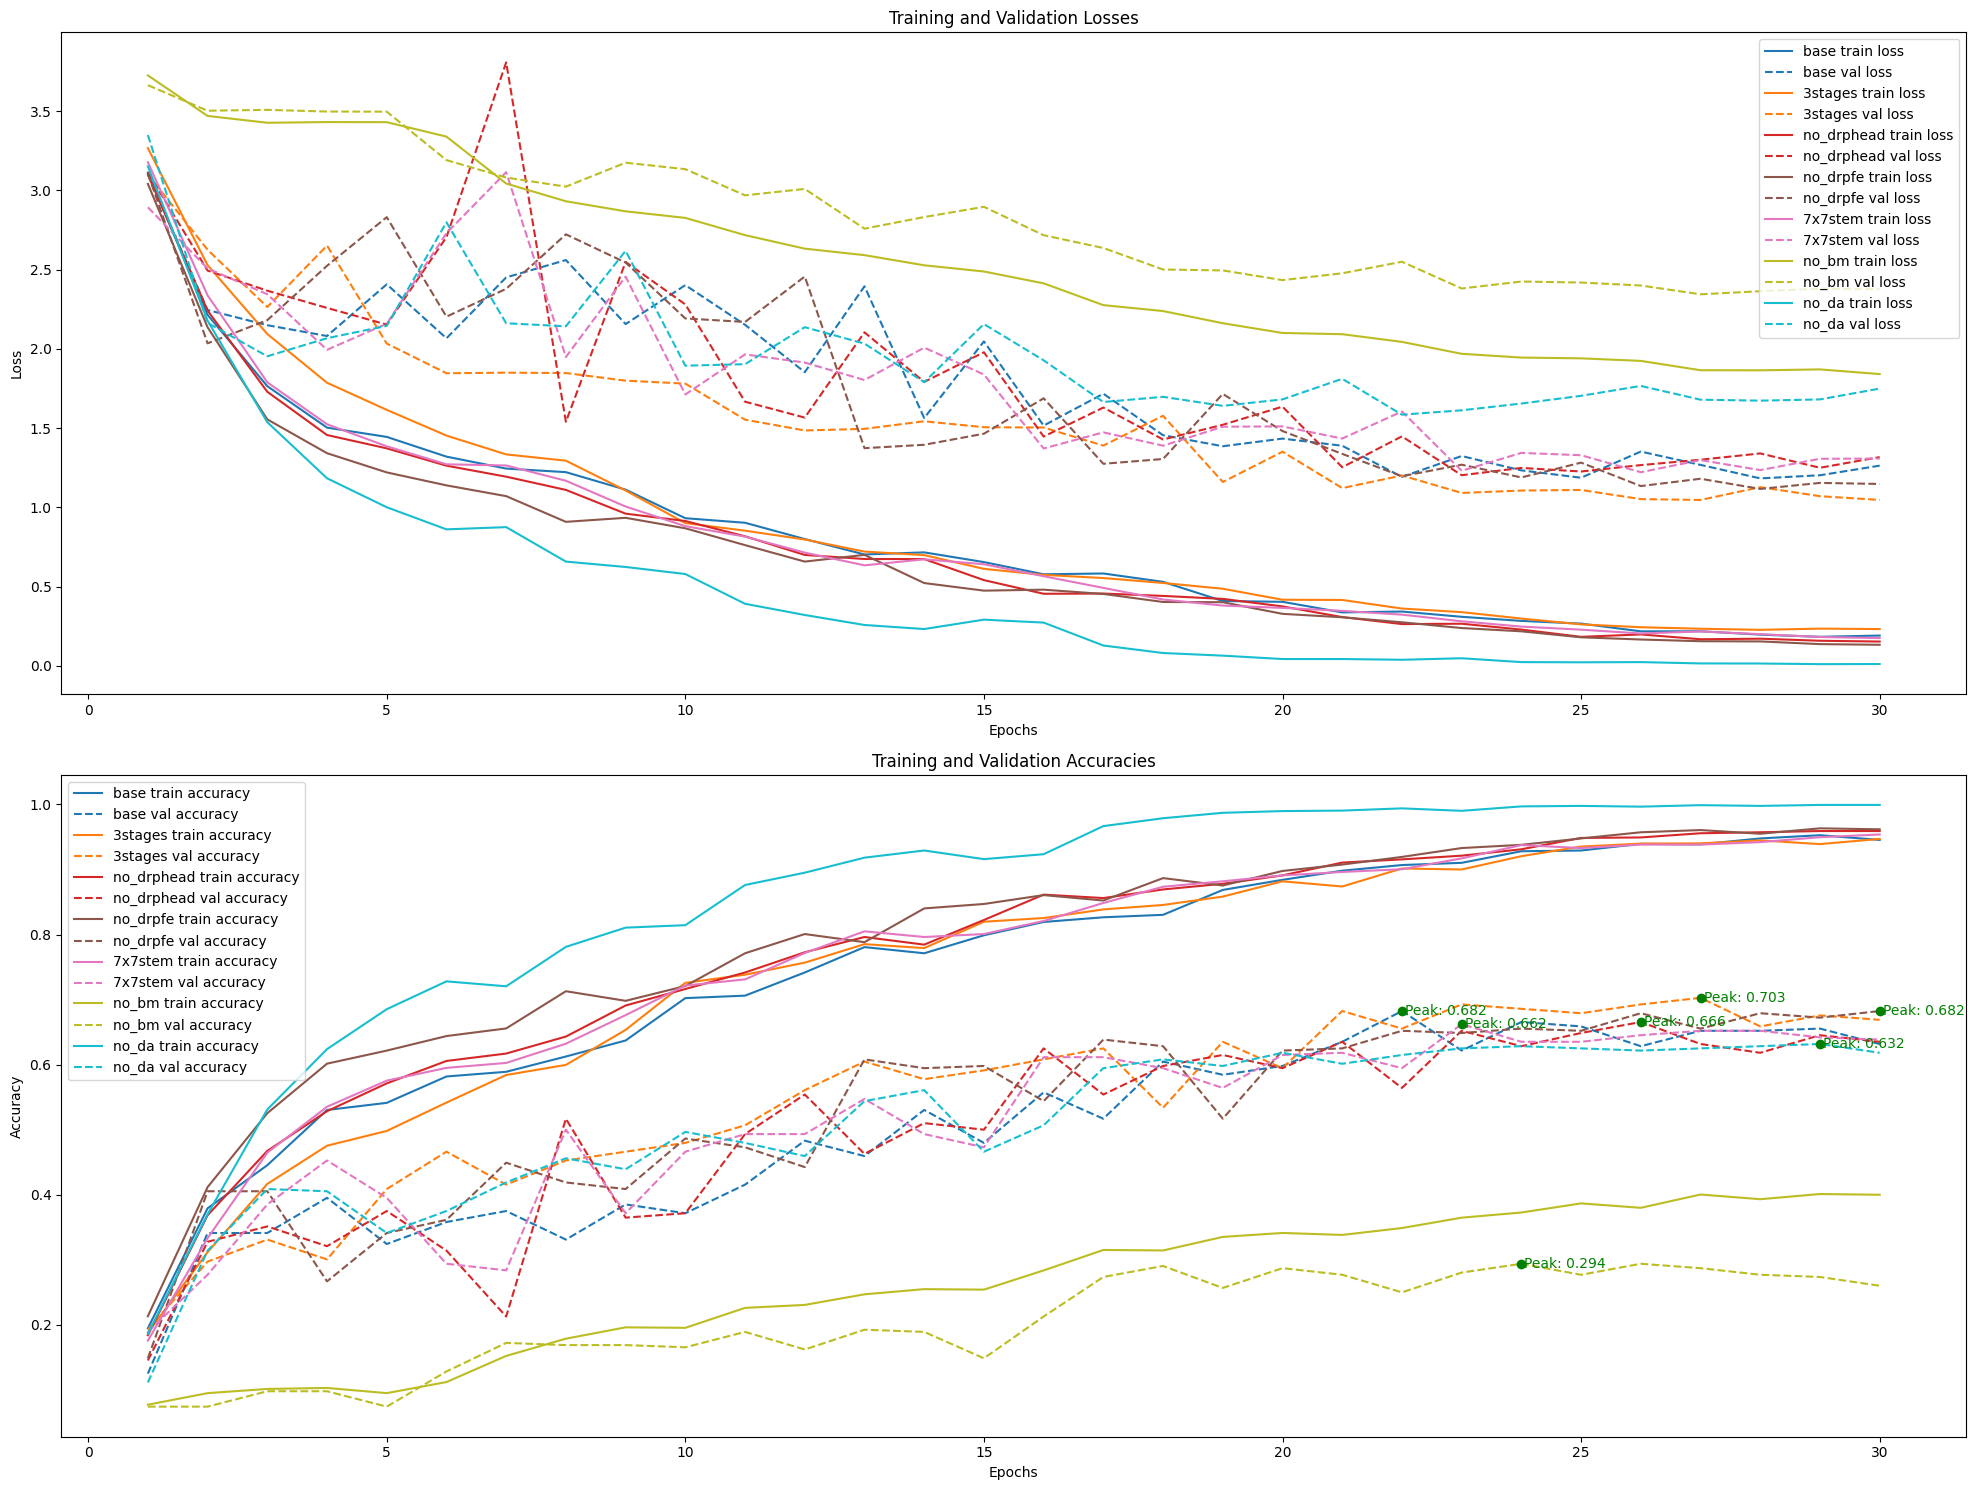

In [42]:
plot_model_histories(histories, results['model_name'], results['best_val_acc'])

In [43]:
results

,model_name,best_val_acc,flops,macs,n_params
0,base,0.682432,271.577 GFLOPS,134.959 GMACs,4.6606 M
1,3stages,0.702703,243.606 GFLOPS,120.999 GMACs,1.223 M
2,no_drphead,0.665541,271.577 GFLOPS,134.959 GMACs,4.6606 M
3,no_drpfe,0.682432,271.577 GFLOPS,134.959 GMACs,4.6606 M
4,7x7stem,0.662162,119.347 GFLOPS,59.1431 GMACs,4.5942 M
5,no_bm,0.293919,270.86 GFLOPS,134.959 GMACs,4.6506 M
6,no_da,0.631757,271.577 GFLOPS,134.959 GMACs,4.6606 M


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.